In [1]:
# importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import scipy
import seaborn as sns
sns.set();



In [2]:
# Reading the data

df_init= pd.read_csv('D:\\Study folder\\ics prereq\\2nd attempt\\ics report 2\\Airbnb_data.csv')
df= df_init.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   log_price           232 non-null    float64
 1   host_response_time  232 non-null    object 
dtypes: float64(1), object(1)
memory usage: 3.8+ KB


In [4]:
df.head()

,log_price,host_response_time
0,5.703782,within a few hours
1,5.003946,within an hour
2,4.553877,within an hour
3,4.653960,within a few hours
4,4.941642,within an hour


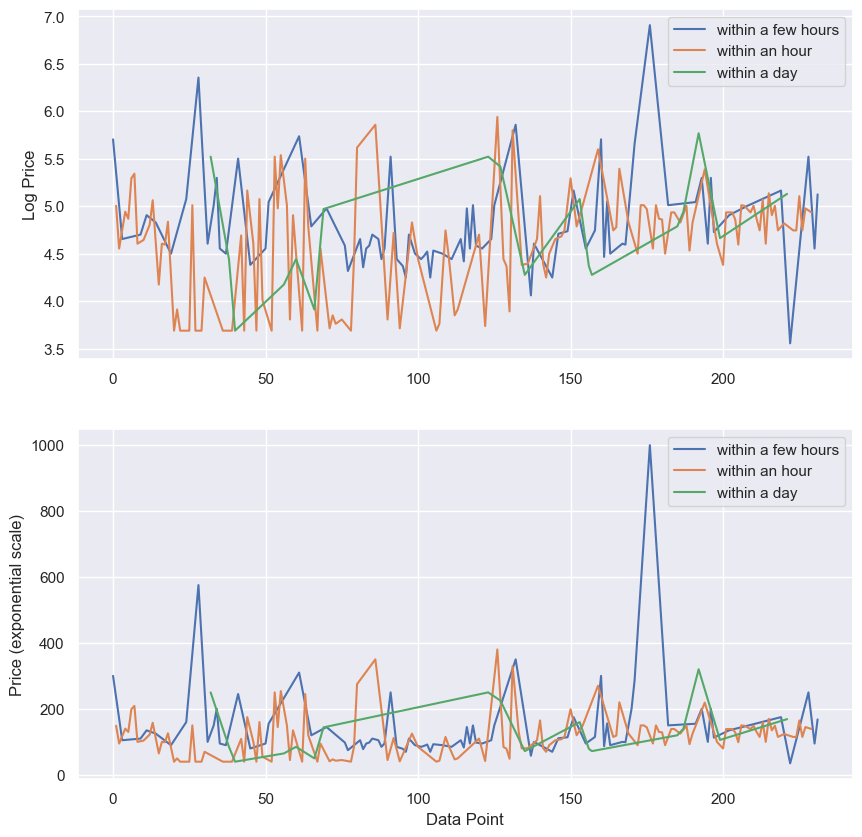

In [5]:
# Plotting the log-price and prices for each category to show the effect on the
#                                                 log transformation on the data variation reduction and data stabilization

plt.figure(figsize= (10, 10))
plt.subplot(2, 1, 1)
plt.plot(df['log_price'][df['host_response_time'] == 'within a few hours'], label='within a few hours')
plt.plot(df['log_price'][df['host_response_time'] == 'within an hour'], label='within an hour')
plt.plot(df['log_price'][df['host_response_time'] == 'within a day'], label='within a day')
plt.legend(loc='best')
plt.ylabel('Log Price')

plt.subplot(2, 1, 2)
plt.plot(np.exp(df['log_price'][df['host_response_time'] == 'within a few hours']), label='within a few hours')
plt.plot(np.exp(df['log_price'][df['host_response_time'] == 'within an hour']), label='within an hour')
plt.plot(np.exp(df['log_price'][df['host_response_time'] == 'within a day']), label='within a day')
plt.legend(loc='best')
plt.xlabel('Data Point')
plt.ylabel('Price (exponential scale)')
plt.show()

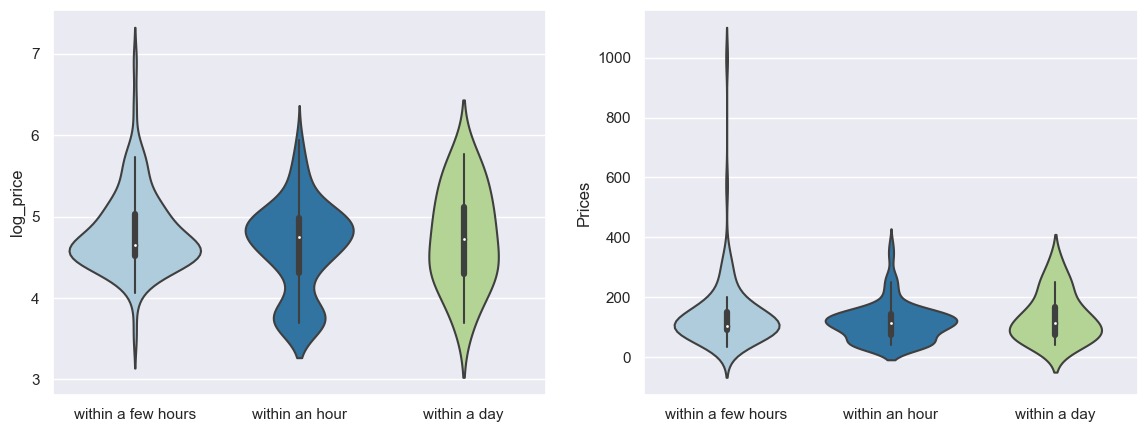

In [6]:
# Violin plot to show the change in data variation with the log transformation

plt.figure(figsize= (14, 5))
plt.subplot(1,2,1)

sns.violinplot(x=df['host_response_time'], y=df['log_price'],
              palette="Paired")
plt.xlabel( '')

plt.subplot(1,2,2)
sns.violinplot(x= df['host_response_time'], y= np.exp(df['log_price']), palette="Paired")
plt.xlabel('')
plt.ylabel('Prices')
plt.savefig('violin.pdf')
plt.show()


# Task 1

In [7]:
df['host_response_time'].unique()

array(['within a few hours', 'within an hour', 'within a day'],
      dtype=object)

In [8]:
# The frequency of the log-price variable on each vategory

freq_time = df['host_response_time'].value_counts()
percent_time = round(df['host_response_time'].value_counts(normalize=True) * 100, 2)

result_time = pd.DataFrame({'Frequency': freq_time,
                            'Percentage': percent_time})
result_time

,Frequency,Percentage
host_response_time,,
within an hour,131,56.47
within a few hours,83,35.78
within a day,18,7.76


In [9]:
# Extracting the summary info of the data

grouped_summary = round(df.groupby('host_response_time')['log_price'].describe(),2)
grouped_summary

,count,mean,std,min,25%,50%,75%,max
host_response_time,,,,,,,,
within a day,18.0,4.74,0.59,3.69,4.30,4.73,5.12,5.77
within a few hours,83.0,4.82,0.50,3.56,4.51,4.65,5.03,6.91
within an hour,131.0,4.61,0.56,3.69,4.31,4.74,4.98,5.94


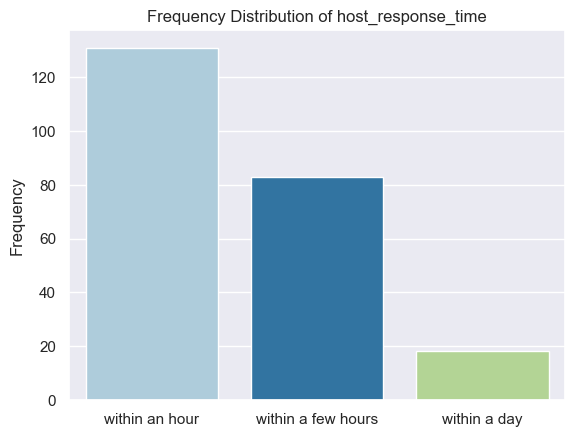

In [10]:
# Visualization for the count of the log-price for each category

sns.barplot(x= result_time.index,  y= 'Frequency', data= result_time, palette= 'Paired');
plt.title('Frequency Distribution of host_response_time')
plt.xlabel('')
plt.savefig('barplot.pdf')
plt.show()

In [11]:
round(df.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
log_price,232.0,4.7,0.55,3.56,4.44,4.7,5.01,6.91


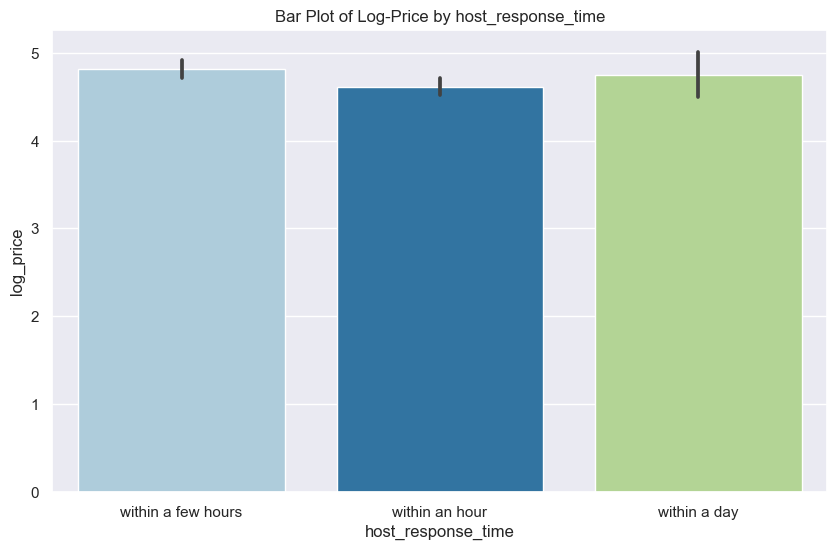

In [12]:
# Box plot for the log-price for each category to show the central measures

plt.figure(figsize= (10,6))
sns.barplot(x='host_response_time', y='log_price', data=df, palette= 'Paired')
plt.title('Bar Plot of Log-Price by host_response_time')
plt.savefig('boxplot.pdf')
plt.show()

# Task 2

First we must control the test assumptions:
    1. the variance of different groups are equal(homoscedasty) by leventest,
    2. The resisulas need to be normally distributed by kolomogrov-smirnoff or Shapiro-Wilk test.

In [13]:
# Extracting the different groups

group1= df['log_price'][df['host_response_time']== 'within a day']
group2= df['log_price'][df['host_response_time']== 'within a few hours']
group3= df['log_price'][df['host_response_time']== 'within an hour']

In [14]:
# Equal variance assumption check via levene test

var_stat, var_pvalue= scipy.stats.levene(group1, group2, group3, center= 'median')

print("Levene's Test:")
print(f"Test Statistic: {round(var_stat , 2)}")
print(f"P-value: {round(var_pvalue , 2)}")

# Interpret the results

alpha = 0.05
if var_pvalue < alpha:
    print("The variances are significantly different.")
else:
    print("There is no significant difference in variances.")

Levene's Test:
Test Statistic: 1.75
P-value: 0.18
There is no significant difference in variances.


In [15]:
# Performing Kolmogorov-Smirnov and Shapiro-Wilk test for the normality of the residuals

formula = f'log_price ~ host_response_time'
model = ols(formula, data=df).fit()

# Get the residuals
residuals = model.resid

count= []
kolmogrov_results= []
shapiro_results = []

# Iterate over categories in 'host_response_time'
for category in df['host_response_time'].unique():
    count= df['log_price'][df['host_response_time']== category].count()
    subset = residuals[df['host_response_time'] == category]
    print(f'Data count in the group "{category}": {count},')
    
    #Shapirp and ks test values extraction
    stat_sh, p_value_sh = stats.shapiro(subset)
    stat_ks, p_value_ks = stats.kstest(subset, 'norm')
    
    shapiro_results.append({'Category': category, 'Statistic Shpiro': round(stat_sh, 3), 'P-Value Shapiro': round(p_value_sh, 3)})
    kolmogrov_results.append({'Category': category, 'Statistic Kolmogrov': round(stat_ks, 3), 'P-Value Kolmogrov': round(p_value_ks, 3)})

shapiro_df = pd.DataFrame(shapiro_results)
Kolmogrov_df= pd.DataFrame(kolmogrov_results)

print('\n')
print('Normality of the residuals for the data groups:', '\n')
print(shapiro_df, '\n')
print(Kolmogrov_df)

Data count in the group "within a few hours": 83,
Data count in the group "within an hour": 131,
Data count in the group "within a day": 18,


Normality of the residuals for the data groups: 

             Category  Statistic Shpiro  P-Value Shapiro
0  within a few hours             0.886            0.000
1      within an hour             0.930            0.000
2        within a day             0.971            0.821 

             Category  Statistic Kolmogrov  P-Value Kolmogrov
0  within a few hours                0.261               0.00
1      within an hour                0.196               0.00
2        within a day                0.174               0.59


In [16]:
# One way Anova to detect the existence of mean difference

anova_stat, anova_pvalue= stats.f_oneway(group1, group2, group3, axis=0)

print('The one-way anova test result for the given data is:')
print(f"statistic:{round(anova_stat,3)} and the p_value id {round(anova_pvalue,3)}", '\n')

t = 3 # number of groups
df1 = 2 # t - 1= 3 - 1
n = 232
df2 = 229 # n -k= 232 - 3
alpha = 0.05

F_value = 3.00
if anova_stat > F_value:
    print('H_0 rejected and the means of all groups are not equal.')
else:
    print('H_0 is not rejected and all groups have eaual mean values')

The one-way anova test result for the given data is:
statistic:3.648 and the p_value id 0.028 

H_0 rejected and the means of all groups are not equal.


# Task 3

In [17]:
# non-adjusted test 

grouped_data = df.groupby('host_response_time')['log_price']

# Perform pairwise t-tests
for group1, group2 in combinations(grouped_data, 2):
    groups_stat, groups_pvalue = ttest_ind(group1[1], group2[1], equal_var=False)  # Assuming unequal variances
    print(f"T-test result between \"{group1[0]}\" and \"{group2[0]}\": ")
    print(f"Test Statistic: {round(groups_stat,3)}")
    print(f"P-value: {round(groups_pvalue,3)}")
    print('\n')


T-test result between "within a day" and "within a few hours": 
Test Statistic: -0.484
P-value: 0.633


T-test result between "within a day" and "within an hour": 
Test Statistic: 0.888
P-value: 0.385


T-test result between "within a few hours" and "within an hour": 
Test Statistic: 2.757
P-value: 0.006




In [18]:
# adjusted test results
# Tukeys method

tukey_results = pairwise_tukeyhsd(endog=df['log_price'], groups=df['host_response_time'], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])

print(tukey_results)


            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
      within a day within a few hours   0.0726 0.8647 -0.2609  0.4061  False
      within a day     within an hour  -0.1312 0.6027 -0.4537  0.1912  False
within a few hours     within an hour  -0.2039 0.0219 -0.3838 -0.0239   True
----------------------------------------------------------------------------


In [19]:
# Bonferroni method 1, using the pingouin package

bonferroni_results = pg.pairwise_tests(dv= 'log_price',
                                       between= 'host_response_time',
                                       padjust= 'bonf',
                                       data= df,
                                       correction= True)

print(bonferroni_results)


             Contrast                   A                   B  Paired  \
0  host_response_time        within a day  within a few hours   False   
1  host_response_time        within a day      within an hour   False   
2  host_response_time  within a few hours      within an hour   False   

   Parametric         T         dof alternative     p-unc    p-corr p-adjust  \
0        True -0.483788   22.671975   two-sided  0.633176  1.000000     bonf   
1        True  0.887698   21.404565   two-sided  0.384570  1.000000     bonf   
2        True  2.756698  187.810374   two-sided  0.006415  0.019244     bonf   

    BF10    hedges  
0  0.291 -0.138366  
1  0.357  0.231443  
2  5.159  0.376443  


In [20]:
# Bonferroni method 2, using statsmodels package

grouped_data = df.groupby('host_response_time')['log_price']

response_times = df['host_response_time'].unique()

statss= []
p_values = []

for group1, group2 in combinations(response_times, 2):
    data1 = grouped_data.get_group(group1)
    data2 = grouped_data.get_group(group2)
    stat, p_value = ttest_ind(data1, data2, equal_var=False)
    statss.append(stat)
    p_values.append(p_value)

alpha = 0.05
reject, corrected_p_values, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')

    
    

# Print the results
combinations_list = list(combinations(response_times, 2))
for i, (group1, group2) in enumerate(combinations_list):
    print(f"T-test between {group1} and {group2}:")
    print(f"Original P-value: {round(p_values[i], 6)}")
    print(f"Bonferroni Corrected P-value: {round(corrected_p_values[i], 6)}")
    print(f"Reject Null Hypothesis: {reject[i]}")
    print("\n")


T-test between within a few hours and within an hour:
Original P-value: 0.006415
Bonferroni Corrected P-value: 0.019244
Reject Null Hypothesis: True


T-test between within a few hours and within a day:
Original P-value: 0.633176
Bonferroni Corrected P-value: 1.0
Reject Null Hypothesis: False


T-test between within an hour and within a day:
Original P-value: 0.38457
Bonferroni Corrected P-value: 1.0
Reject Null Hypothesis: False


